<a href="https://colab.research.google.com/github/omarahmed999/Rnnsentimentassignment/blob/main/assignment_using_imdb_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load and prepare data
# For this example, we'll use the IMDB movie review dataset
def load_data():
    # Load the IMDB dataset from Keras
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

    # Get the word index mapping
    word_index = tf.keras.datasets.imdb.get_word_index()

    # Create a reverse mapping
    reverse_word_index = {value: key for key, value in word_index.items()}

    # Function to decode reviews
    def decode_review(text):
        return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

    # Decode some examples
    x_train_decoded = [decode_review(x) for x in x_train[:5]]

    return (x_train, y_train), (x_test, y_test), x_train_decoded

# 2. Preprocess the data
def preprocess_data(x_train, x_test, max_len=200):
    # Pad sequences to ensure uniform length
    x_train_pad = pad_sequences(x_train, maxlen=max_len, padding='post')
    x_test_pad = pad_sequences(x_test, maxlen=max_len, padding='post')

    return x_train_pad, x_test_pad

# 3. Build the RNN model
def build_rnn_model(vocab_size=10000, embedding_dim=128, rnn_units=64, max_len=200):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_len),

        # RNN layer
        SimpleRNN(rnn_units, return_sequences=False),

        # Dropout for regularization
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# 4. Train the model
def train_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=128):
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1
    )

    return history


In [ ]:

# 5. Evaluate the model
def evaluate_model(model, x_test, y_test):
    # Get model predictions
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Return predictions for further analysis
    return y_pred, y_pred_prob

# 7. Make predictions on new text
def predict_sentiment(model, text, tokenizer, max_len=200):
    # Tokenize and pad the new text
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Make prediction
    prediction = model.predict(padded_sequences)[0][0]

    # Interpret the results
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence


In [ ]:
# 8. Main function to run the sentiment analysis
def run_sentiment_analysis():
    print("Loading data...")
    (x_train, y_train), (x_test, y_test), sample_reviews = load_data()

    # Print sample reviews
    print("\nSample reviews:")
    for i, review in enumerate(sample_reviews):
        print(f"Review {i+1}: {review[:100]}... | Sentiment: {'Positive' if y_train[i] == 1 else 'Negative'}")

    print("\nPreprocessing data...")
    max_len = 200
    x_train_pad, x_test_pad = preprocess_data(x_train, x_test, max_len)

    # Split training data to create a validation set
    x_train_final, x_val, y_train_final, y_val = train_test_split(
        x_train_pad, y_train, test_size=0.1, random_state=42
    )

    print("\nBuilding RNN model...")
    vocab_size = 10000
    embedding_dim = 128
    rnn_units = 64
    model = build_rnn_model(vocab_size, embedding_dim, rnn_units, max_len)
    model.summary()

    print("\nTraining the model...")
    history = train_model(model, x_train_final, y_train_final, x_val, y_val, epochs=5)

    print("\nEvaluating the model...")
    y_pred, y_pred_prob = evaluate_model(model, x_test_pad, y_test)

    print("\nPlotting training history...")
    plot_history(history)

    print("\nModel is ready for sentiment analysis!")

    return model, x_train, y_train


In [ ]:
# 9. Custom data example
def custom_data_example():
    """Example using a custom dataset instead of IMDB"""
    # Load your custom data
    # Example format: DataFrame with 'text' and 'sentiment' columns
    # df = pd.read_csv('your_sentiment_data.csv')

    # For demonstration, we'll create a small sample dataset
    texts = [
        "I really loved this movie, it was amazing!",
        "The acting was good but the plot was boring",
        "Terrible experience, would not recommend",
        "The best film I've seen all year",
        "Somewhat entertaining but not worth the money"
    ]

    labels = [1, 0, 0, 1, 0]  # 1 for positive, 0 for negative

    # Create a DataFrame
    df = pd.DataFrame({'text': texts, 'sentiment': labels})

    # Split into train and test sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Tokenize the text
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(train_df['text'])

    # Convert text to sequences
    X_train = tokenizer.texts_to_sequences(train_df['text'])
    X_test = tokenizer.texts_to_sequences(test_df['text'])

    # Pad sequences
    max_len = 100
    X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test, maxlen=max_len, padding='post')

    # Get labels
    y_train = train_df['sentiment'].values
    y_test = test_df['sentiment'].values

    # Build and train model
    vocab_size = len(tokenizer.word_index) + 1
    model = build_rnn_model(vocab_size=vocab_size, max_len=max_len)

    history = train_model(
        model,
        X_train_pad, y_train,
        X_test_pad, y_test,
        epochs=10
    )

    # Make a prediction on new text
    new_text = "This was an absolutely fantastic movie with great performances"
    sentiment, confidence = predict_sentiment(model, new_text, tokenizer, max_len)
    print(f"Text: {new_text}")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2f})")

    return model, tokenizer


In [ ]:
# Run the main function if this script is executed
if __name__ == "__main__":
    # Uncomment one of these to run
    # model, x_train, y_train = run_sentiment_analysis()
    # model, tokenizer = custom_data_example()
    print("Script loaded successfully. Call run_sentiment_analysis() or custom_data_example() to execute.")

Script loaded successfully. Call run_sentiment_analysis() or custom_data_example() to execute.


Loading data...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Sample reviews:
Review 1: ? this film was just brilliant casting location scenery story direction everyone's really suited the... | Sentiment: Positive
Review 2: ? big hair big boobs bad music and a giant safety pin these are the words to best describe this terr... | Sentiment: Negative
Review 3: ? this has to be one of the worst films of the 1990s when my friends i were watching this film being... | Sentiment: Negative
Review 4: ? the ? ? at storytelling the traditional sort many years after the event i can still see in my ? ey... | Sentiment: Positive
Review 5: ? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's s... | Sentiment: Negative

Preprocessing data...

Building RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 162ms/step - accuracy: 0.5093 - loss: 0.6995 - val_accuracy: 0.5356 - val_loss: 0.6766
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.6576 - loss: 0.6270 - val_accuracy: 0.5860 - val_loss: 0.6794
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.6058 - loss: 0.6877 - val_accuracy: 0.5392 - val_loss: 0.6734
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.6099 - loss: 0.6285 - val_accuracy: 0.5644 - val_loss: 0.6761
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.7019 - loss: 0.5125 - val_accuracy: 0.5496 - val_loss: 0.7314

Evaluating the model...
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step
              precision    recall  f1-score   support

           0       0.55      0.60      0.57     12500
           1       0.56      0.50      0.53     12500

    accuracy                           0.55     25000
   macro avg       0.55      0.55      0.

NameError: name 'test_model_with_samples' is not defined

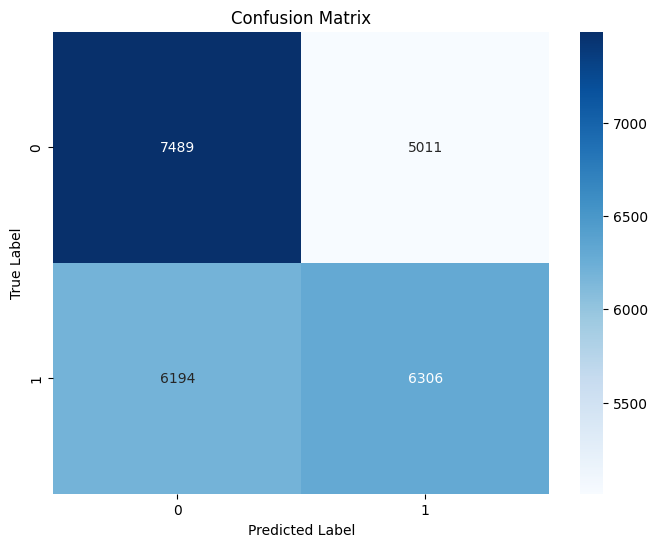

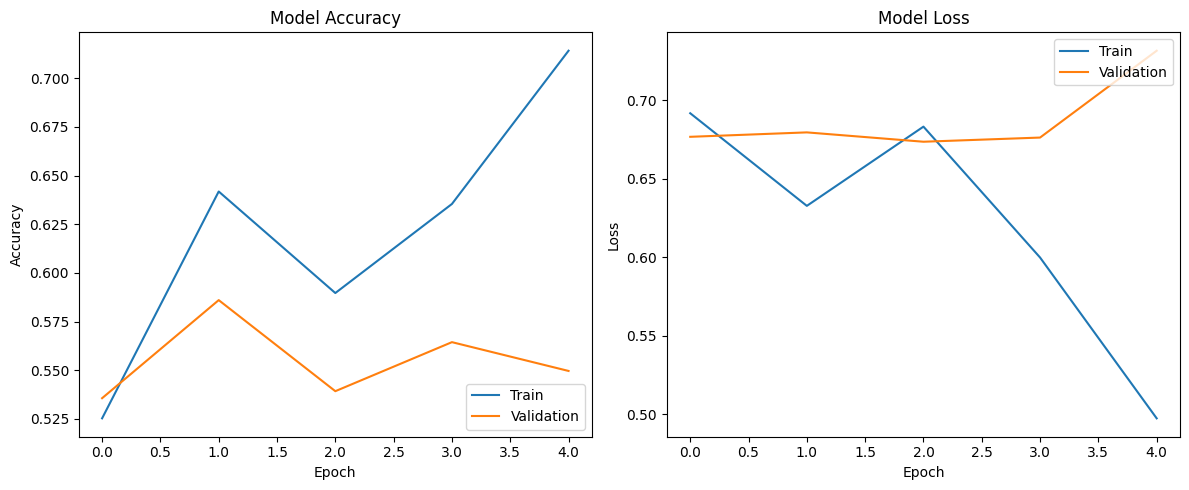

In [ ]:
# After training your model
model, x_train, y_train = run_sentiment_analysis()

# Test with pre-defined sample texts
test_model_with_samples(model)

# Find and analyze misclassifications
analyze_misclassifications(model, x_test_pad, y_test)

# Test with your own input texts
interactive_testing(model)